In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

# What is Dysarthria ?
- Weakness in the muscles used for speech, which often causes slowed or slurred speech.
- Dysarthria is a condition in which the part of your brain that controls your lips, tongue, vocal cords, and diaphragm doesn't work well. It's hard for you to move those muscles the right way. It’s often brought on by a disease.
- Some people with dysarthria have only minor speech problems. Others have so much trouble getting their words out that other people may not be able to understand them very well.

<img src='https://i.ytimg.com/vi/gD80xdT_uLE/maxresdefault.jpg' >

# Data Visualization and EDA

In [3]:
directory = '../input/dysarthria-detection'
data = pd.read_csv("../input/dysarthria-detection/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
1,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
2,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
3,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
4,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
...,...,...,...
1995,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...
1996,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...
1997,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...
1998,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...


## Visualization Functions: Features and Plots
- Waveplot
- Spectrogram
- Zero Crossing Rate
- Spectral Centroids
- Spectral Rolloff
- MFCCs
- Mel Spectrogram

In [4]:
def show_waveplot(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")
    
def show_zcr(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()
    
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()
    
def show_spectral_rolloff(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()
    
def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()
    
def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()  

## Fetching Audio Samples: Gender and Dysarthric Case

<img src='https://miro.medium.com/max/1400/1*VJjx0bUAhZ9gPWpm3yIesw.jpeg'>

In [5]:
data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

## Male and Dysarthric

In [6]:
ipd.Audio(male_dysarthric.iloc[0].filename)

## Female and Dysarthric

In [7]:
ipd.Audio(female_dysarthric.iloc[0].filename)

## Male and Non Dysarthric

In [8]:
ipd.Audio(male_ndysarthric.iloc[0].filename)

## Female and Dysarthric

In [9]:
ipd.Audio(female_ndysarthric.iloc[0].filename)

## Waveplots
- For the dysarthric samples it can be observed that the one male sample taken here has a slurred speech as is evident by the waveplot, while for the female sample the speech is quite rapid and difficult to understand due to the words overlapping with each other as is indicative by the box like patterns forming in the waveplot
- The Non dysarthric samples have a regular waveplot indicating a regular paced speech 

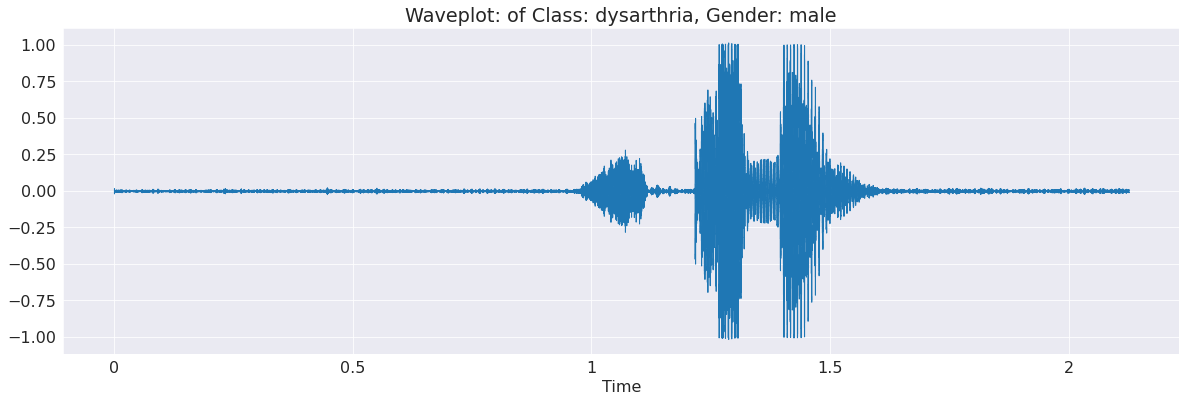

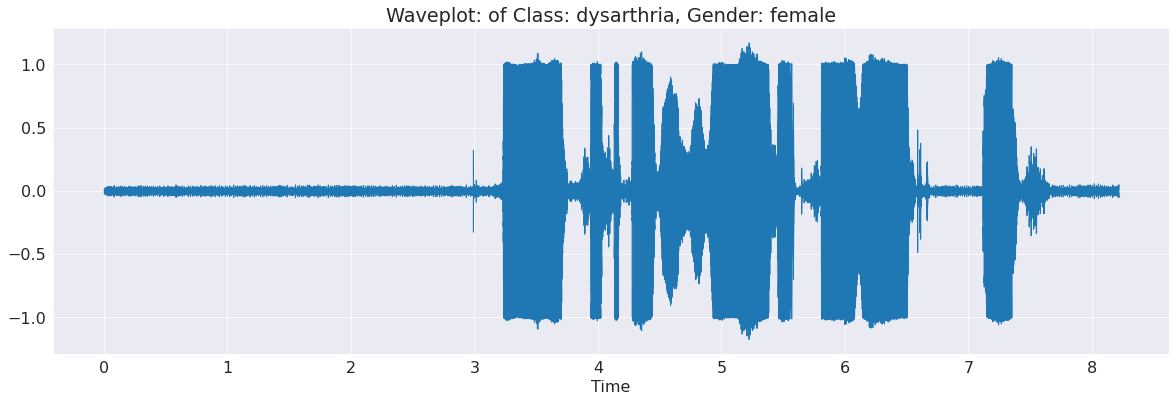

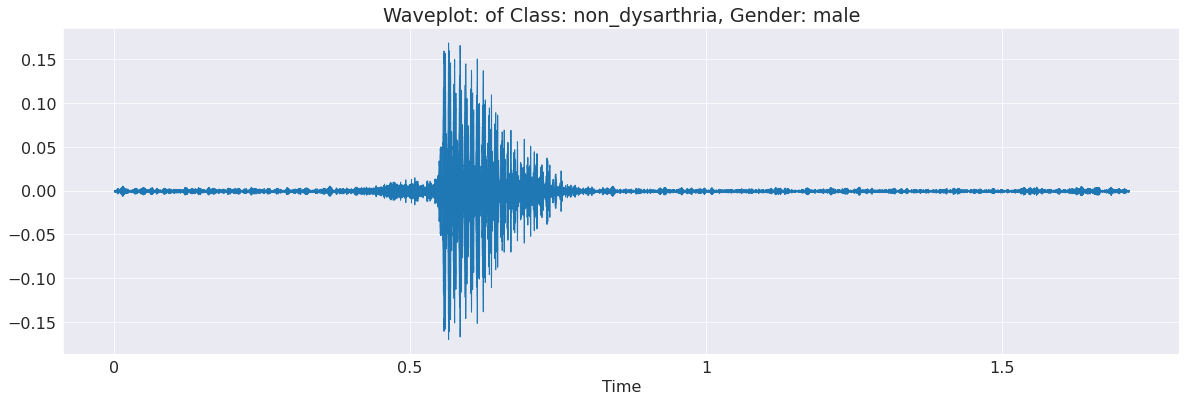

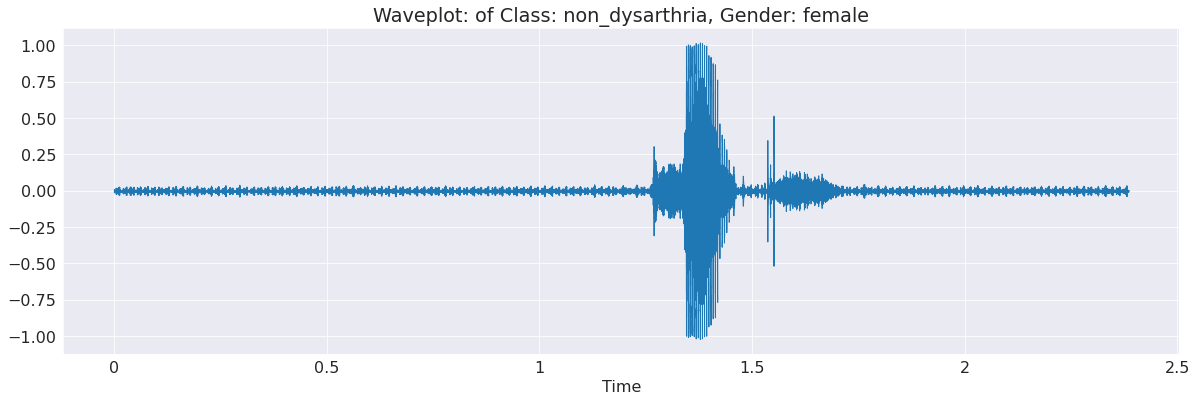

In [10]:
show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_waveplot(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_waveplot(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

## Spectrograms
- For the dysarthric samples it can be seen that the energy magnitudes of the frequencies are more spread out across time, indicative of slow and slurred speech or due to the fact that the words are coming out more rapidly and are overlapping with each other. Similar patterns might also be possible for a person who is dysarthric and speaks monotonously 
- For the Non dysarthric samples it can be seen that the energy magnitudes are more narrowed to only the parts where they have spoken something, which is regular paced

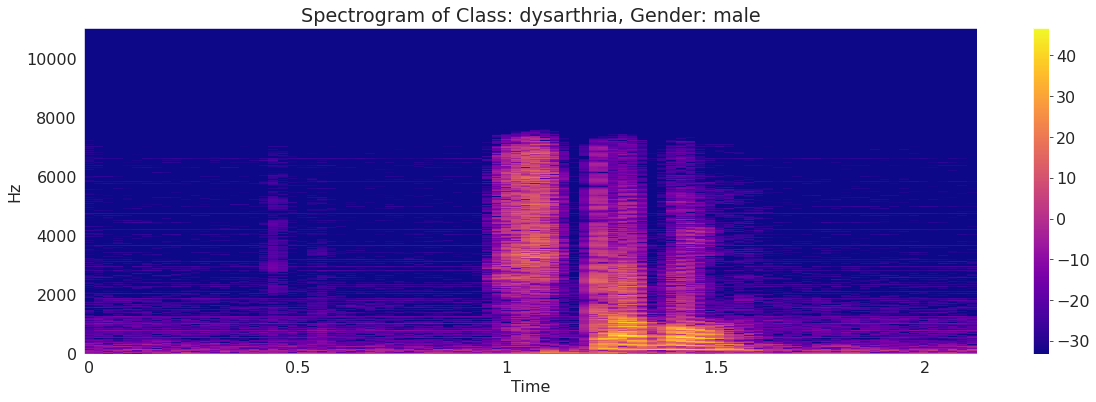

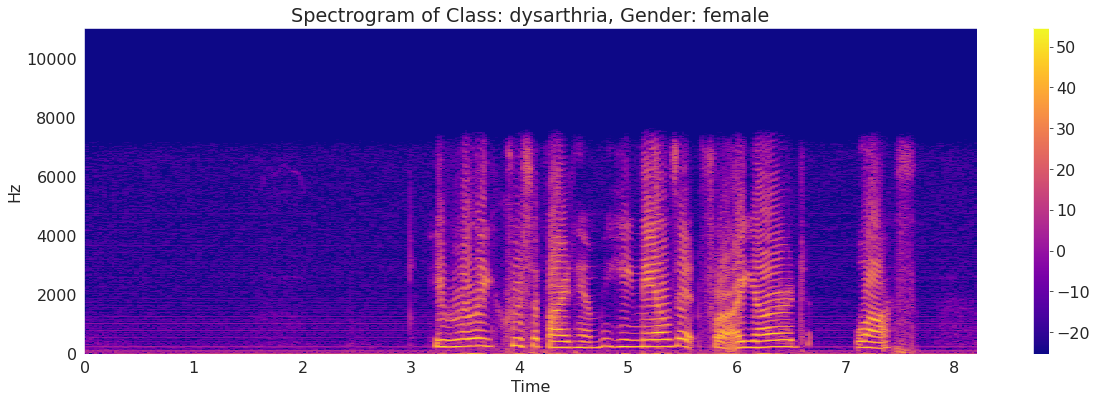

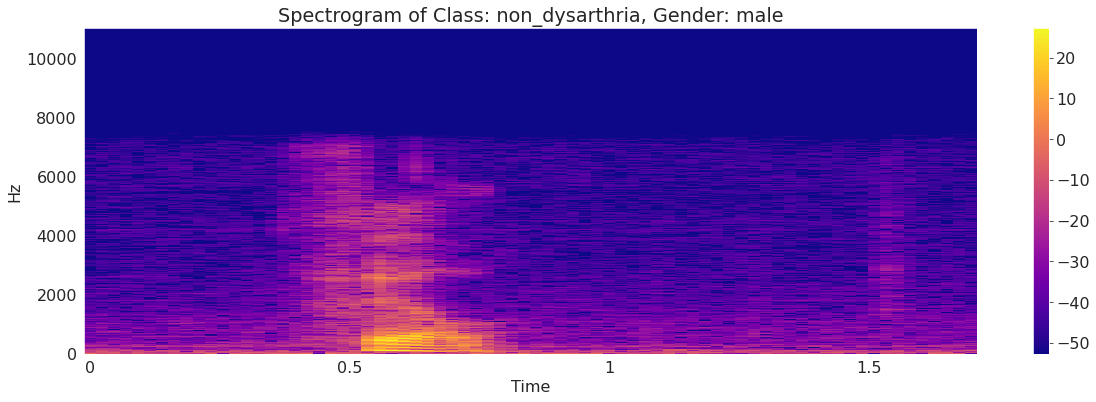

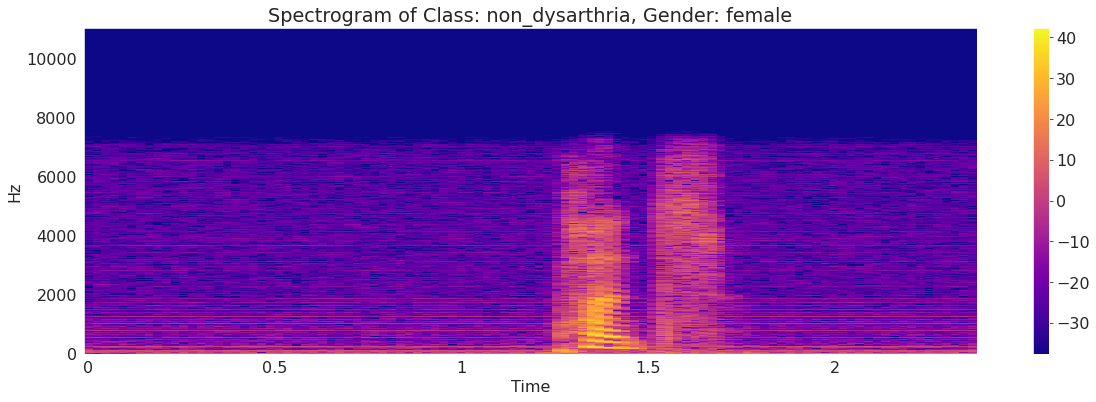

In [11]:
show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectrogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectrogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectrogram(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

## Zero Crossing Rate
- For dysarthric samples it can be observed that in audio itself their were instances where some of their words sentence were relatively louder (e.g. for the female dysarthric case) and therefore there are multiple peaks of zero crossing rate in those cases. This sudden loudness of certain words might be due to their lack of control over their tongue and other mouth related muscles while speaking and not being able to stress words intentionally 
- For the Non dysarthric cases the zero crossing rate is high in those instances of time where the speaker's voice is audible

Sum of zero crossing  2504


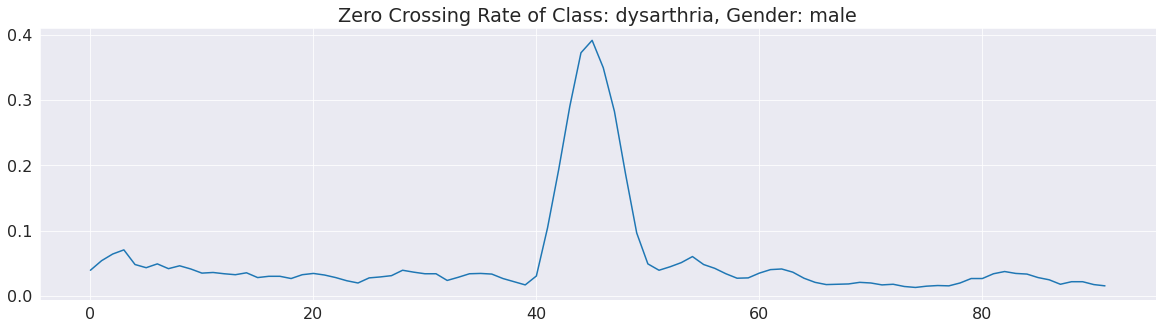

Sum of zero crossing  14598


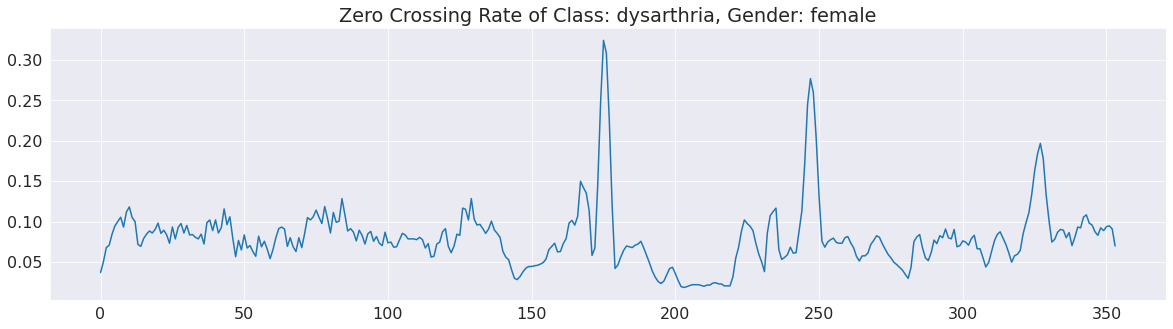

Sum of zero crossing  2342


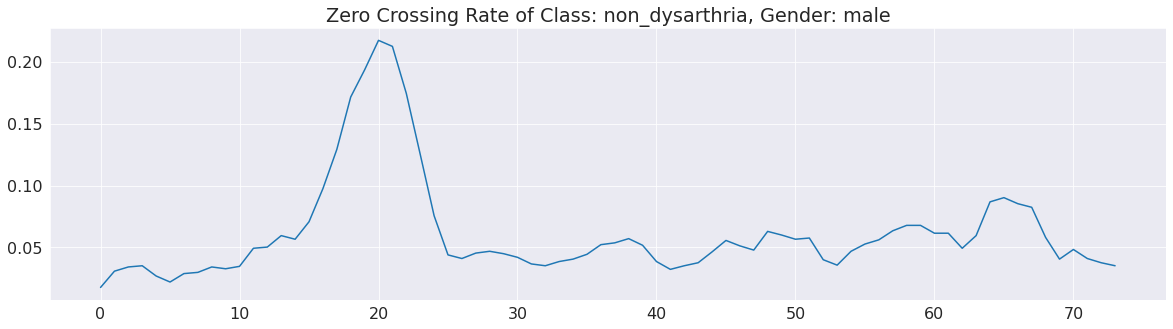

Sum of zero crossing  4458


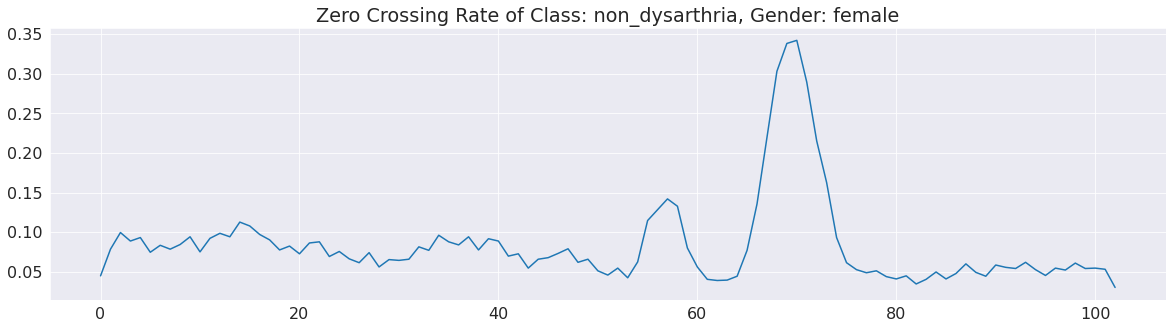

In [12]:
show_zcr(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_zcr(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_zcr(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_zcr(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

## Spectral Centroid
- Spectral centroids indicate where the center of mass of the spectrum is located
- The centroids are usually high when there is no speech and become low in those instances of times where speech is present in the audio
- For dysarthric samples it can be seen that since the speech is slurred the centroid values go down for a while and go back up as soon as there are some small pauses
- For non dysarthric samples, the centroids are down for a little while where the speech is present in the audio and they go back up again as soon as their is no speech in the audio

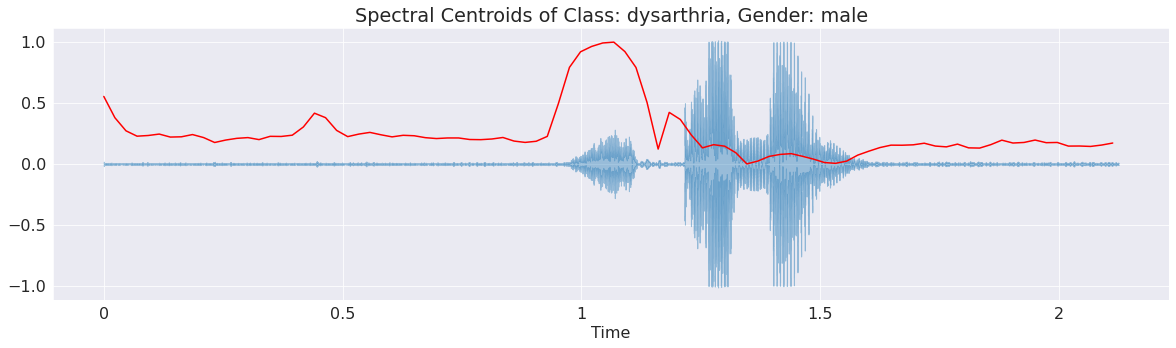

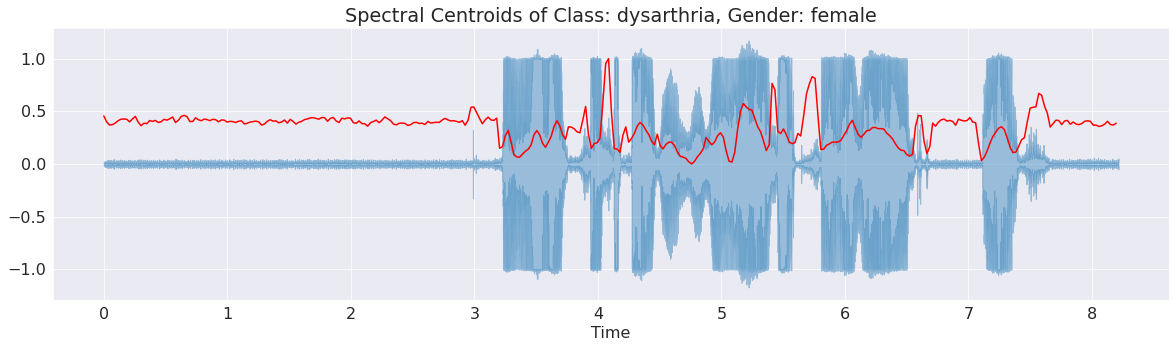

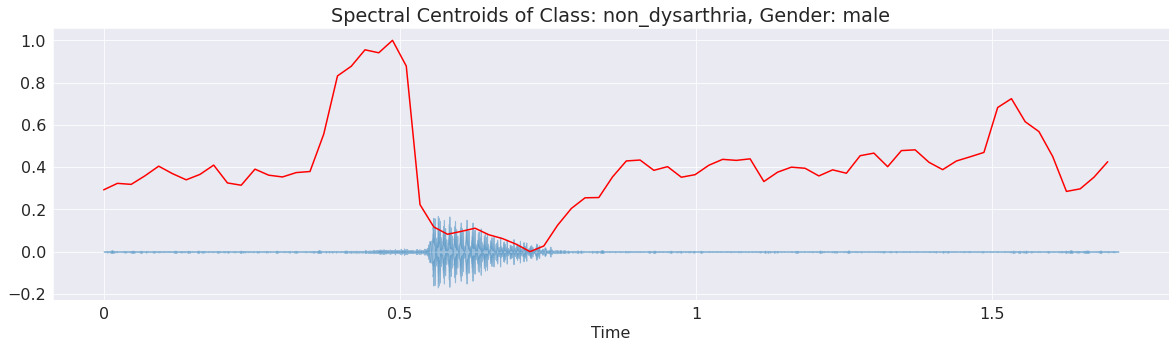

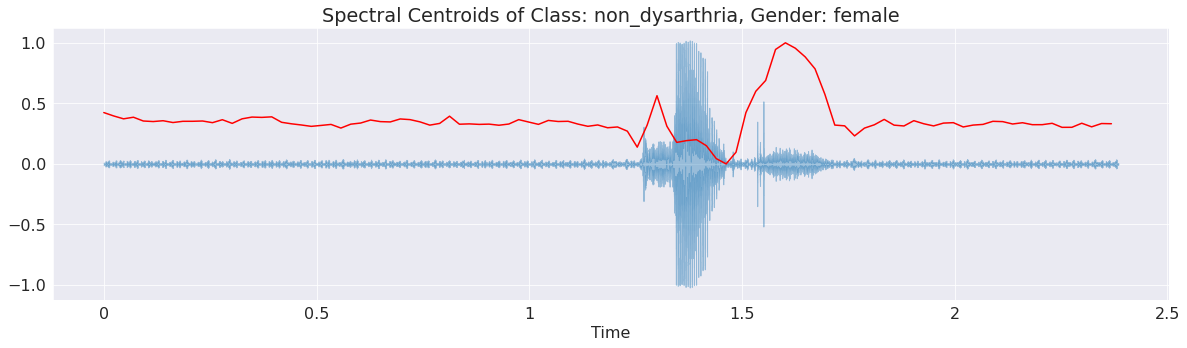

In [13]:
show_spectral_centroids(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectral_centroids(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectral_centroids(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectral_centroids(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

## Spectral Rolloff
- Spectral Rolloffs indicate the frequency below which some % (librosa: 85%) of the magnitude distribution is concentrated
- As we had previously observed in the spectrograms the energy magnitudes of the frequencies are more spread out in the case of dysarthric samples, the 85% coverage below the rolloff frequency can be seen enclosing the speech present in the audio signal
- For non dysarthric samples we can see that the 85% coverage encloses the speech as well as some other disturbances/noise in the audio

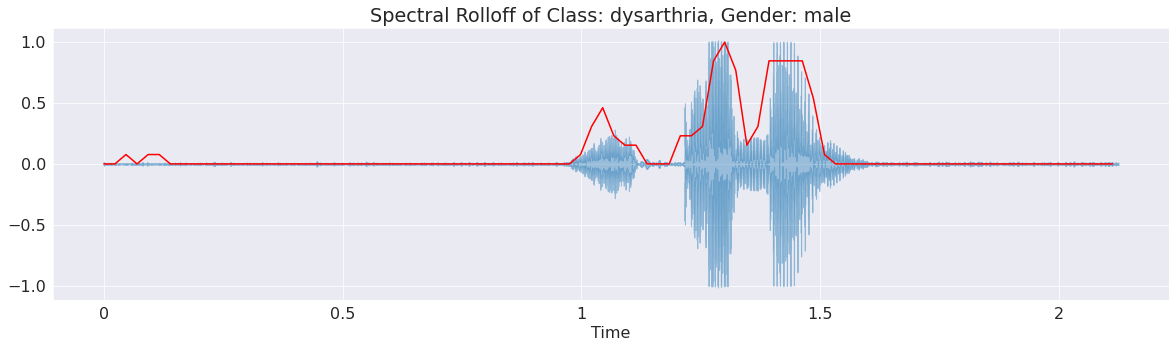

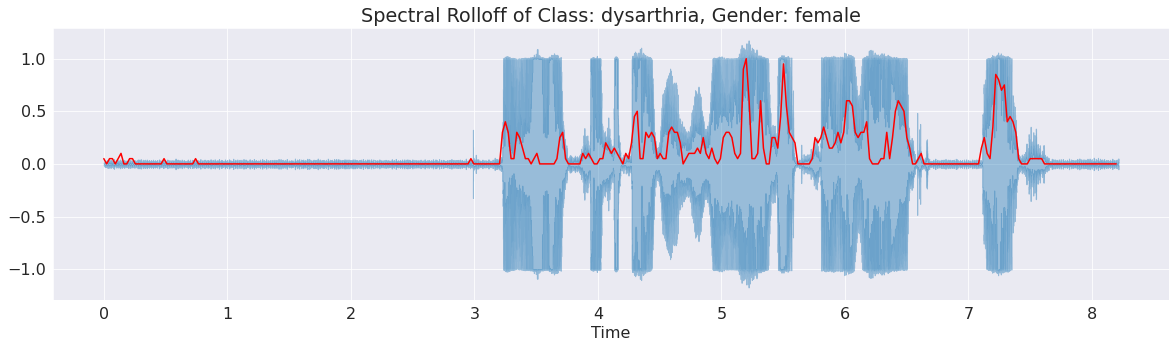

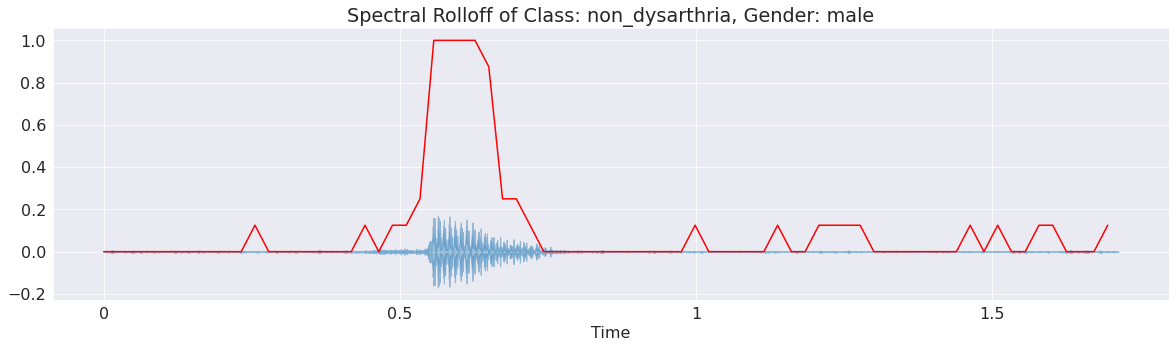

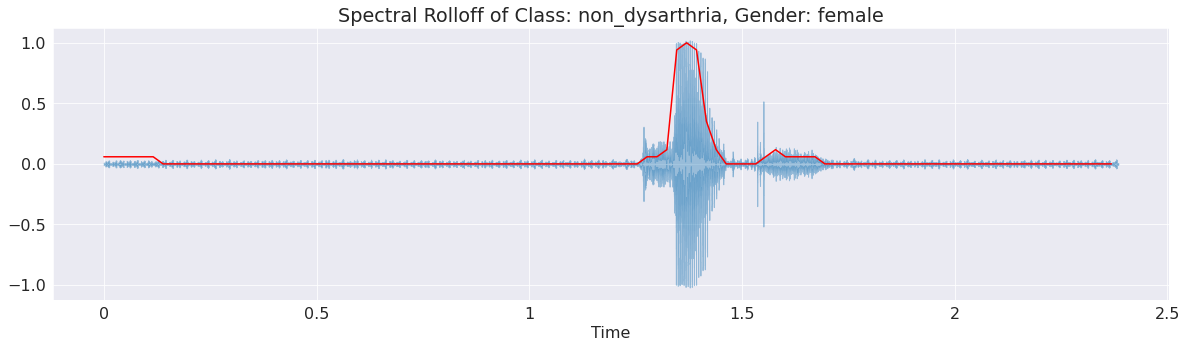

In [14]:
show_spectral_rolloff(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectral_rolloff(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectral_rolloff(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectral_rolloff(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

## MFCCs
- For dysarthric samples the MFCC visualization has much more darker and concentrated pixels indicating the slurs present in their speech
- For non dysarthric it is not as concentrated and is more spread out 

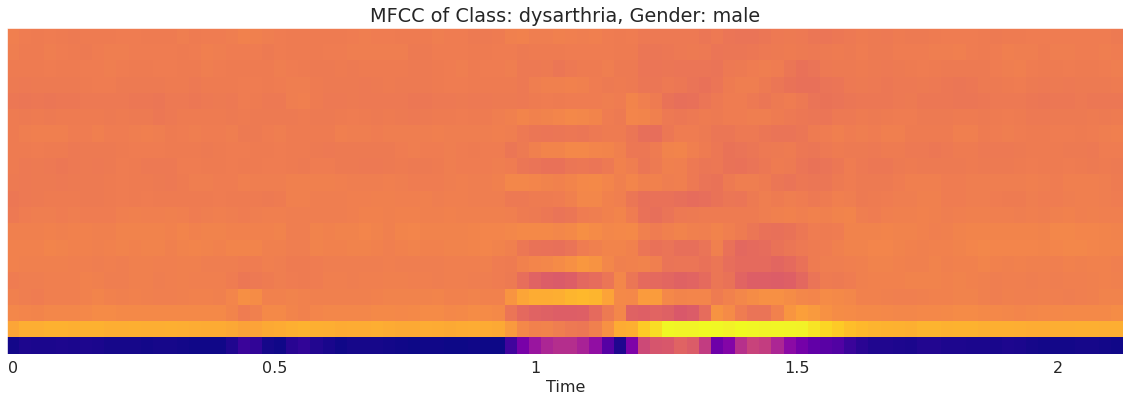

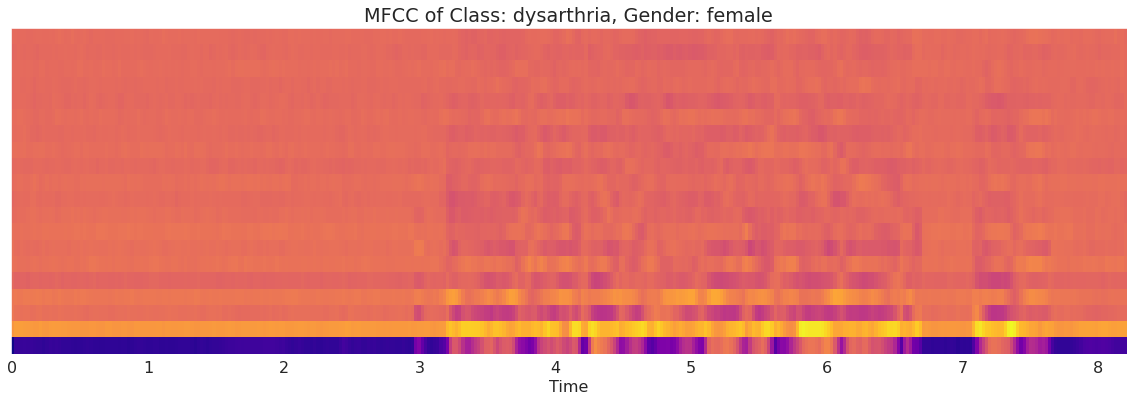

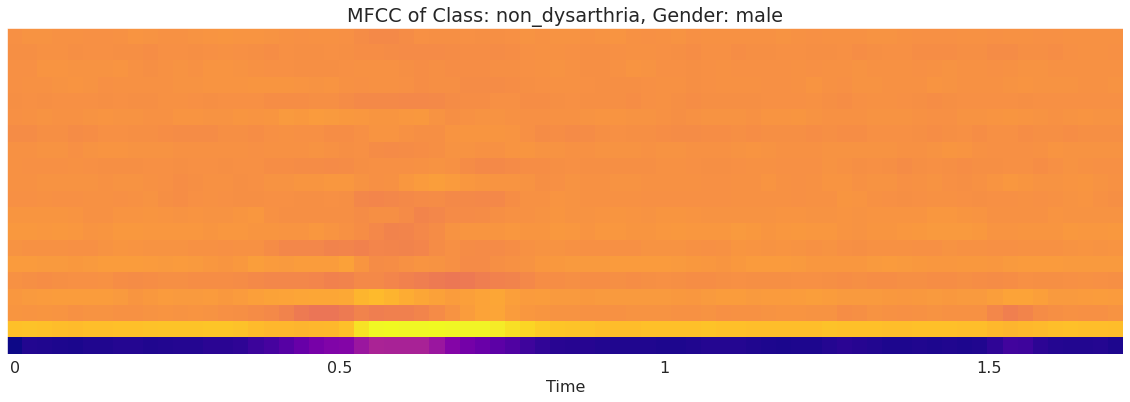

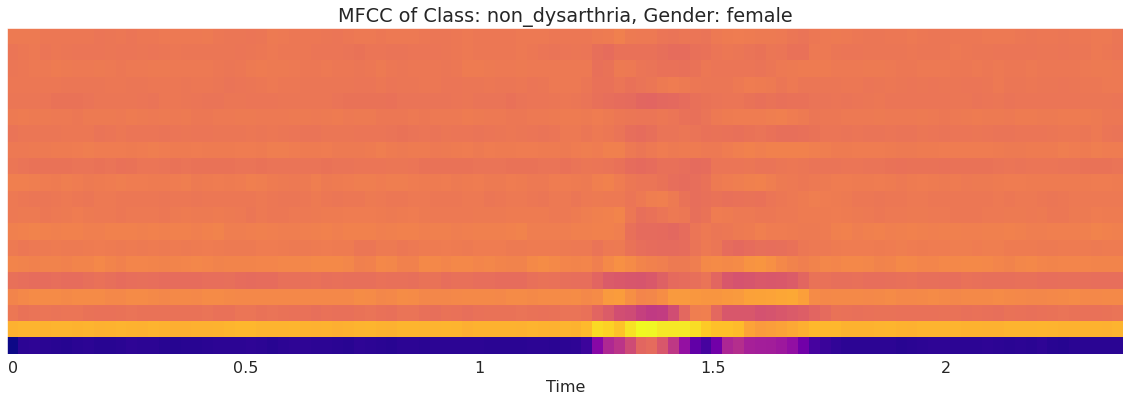

In [15]:
show_mfccs(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_mfccs(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_mfccs(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_mfccs(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

## Mel Spectrogram
- The Spectrogram converted to Mel scale is showing the magnitudes that are more perceptual to the human ears generally
- Patterns in the mel spectrograms of the dysarthric samples are somewhat indicative of the slurs in the speech 

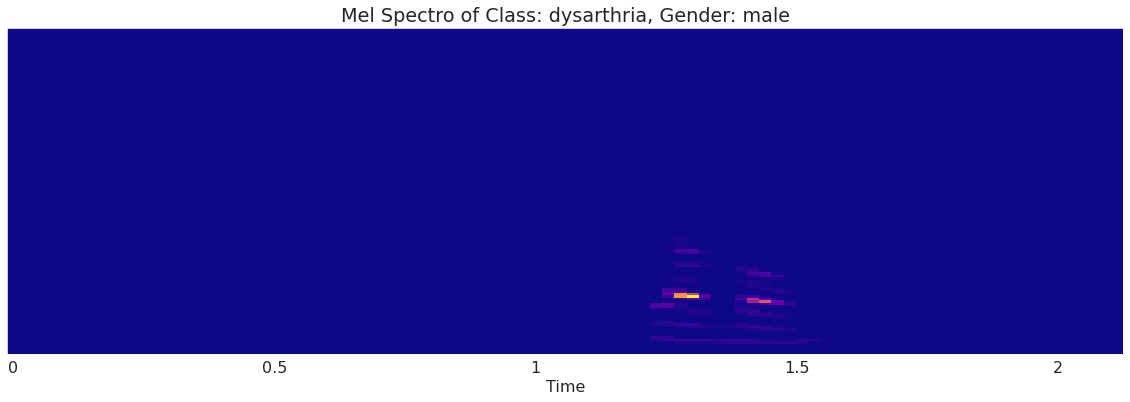

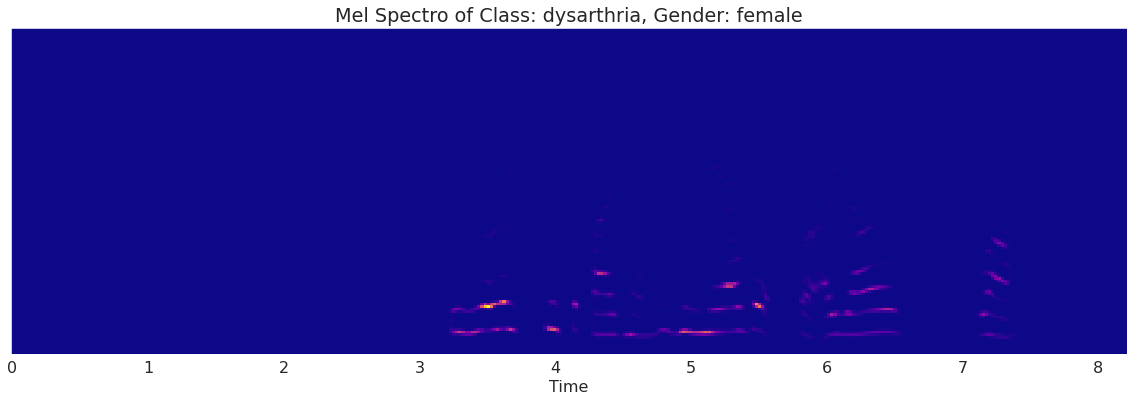

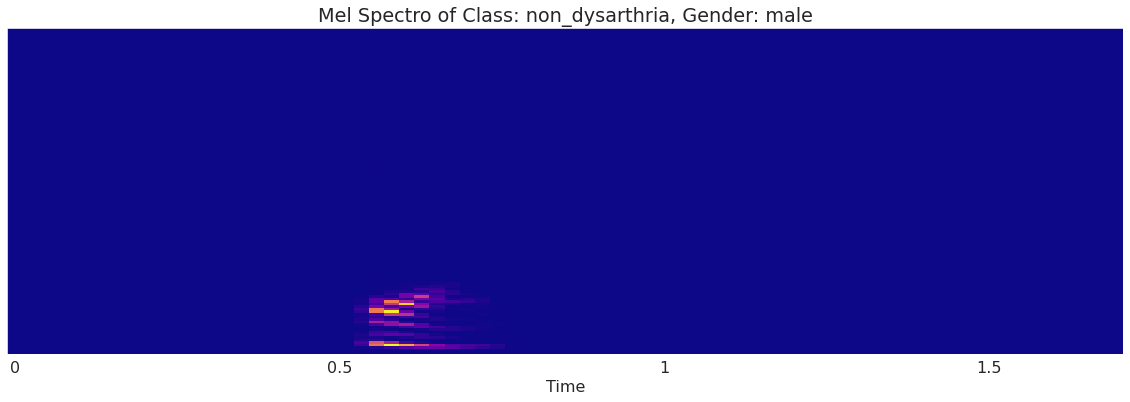

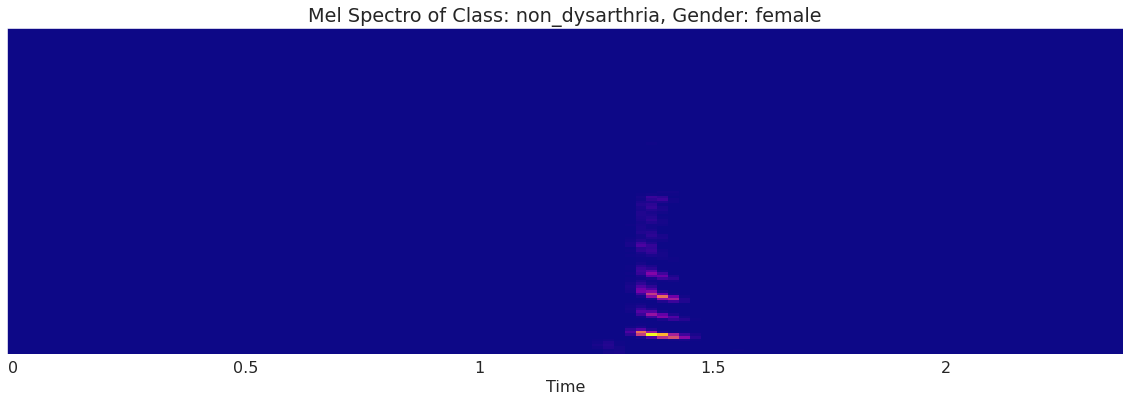

In [16]:
show_melspectro(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_melspectro(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_melspectro(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_melspectro(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

# Feature Extraction
- Extracts 128 MFCC Features, which was the maximum possible features during the extraction process

<img src='https://devopedia.org/images/article/340/9044.1621765887.png'>

In [51]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

In [18]:
def feature_extraction(df):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            features.append(mean_mfcc)
        except EOFError:
            pass
        
    dataf = pd.DataFrame(features)
    dataf['class'] = df['is_dysarthria']
    return dataf

In [19]:
dataf = feature_extraction(data)

100%|██████████| 2000/2000 [05:16<00:00,  6.33it/s]


In [20]:
dataf

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-222.457077,102.146935,-17.265686,38.949039,-13.736136,20.581657,-5.038507,9.669348,2.852035,-1.724100,...,0.959738,0.782641,0.988810,0.482095,-0.025945,0.654508,0.499423,0.240431,-0.257057,non_dysarthria
1,-300.215210,110.792397,-17.835419,39.316513,-17.007551,22.735220,2.369241,17.929928,4.389093,3.490597,...,1.091978,0.965665,1.435454,-0.224936,-1.078653,-0.329877,0.278370,-0.274176,-0.642529,non_dysarthria
2,-303.913361,113.325172,-24.710556,45.542671,-22.632982,26.017168,1.537213,17.134033,5.634882,3.570631,...,0.793990,0.478094,1.164105,-0.163656,-1.209489,0.024640,0.433807,-0.406458,-0.485287,non_dysarthria
3,-211.974976,117.983017,-36.248325,38.447906,-27.372046,25.304882,-6.710573,11.927542,0.885225,2.587593,...,0.547349,0.990486,0.629700,0.259464,-0.164846,0.062285,0.314661,-0.045342,-0.274535,non_dysarthria
4,-281.211090,105.812836,-18.269186,45.741081,-15.748901,27.830769,-2.712293,15.742901,5.896017,0.358894,...,1.533421,0.922572,0.878170,0.324768,0.115258,-0.145911,-0.038609,-0.655331,-0.362039,non_dysarthria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-304.561401,115.796066,-1.147701,26.770647,-0.757051,13.096489,2.627126,3.931506,-0.938713,-3.080619,...,0.448663,0.153010,0.244165,0.094611,-0.138421,0.272110,0.265663,0.062699,-0.247763,dysarthria
1995,-458.009277,110.334679,22.025970,0.062627,-11.206986,3.119710,-4.342128,4.252670,6.066456,-2.170707,...,0.626071,0.484599,0.440195,0.401546,0.409377,0.226709,0.203481,-0.091866,0.021844,dysarthria
1996,-371.707428,117.062241,5.491239,22.597092,8.194892,7.680684,9.125202,9.802479,4.609561,3.364675,...,0.226508,-0.020404,0.015430,-0.066805,-0.199373,0.489964,0.809572,-0.329458,-0.373760,dysarthria
1997,-302.861511,112.991661,-4.898696,32.754093,-1.607929,4.021253,4.864986,9.357003,-2.490314,-3.998960,...,0.125244,-0.171940,0.354822,0.195992,-0.417778,0.448446,1.017736,-0.065310,-0.120946,dysarthria


In [21]:
dataf.loc[dataf['class']=='non_dysarthria','class'] = 0.0
dataf.loc[dataf['class']=='dysarthria','class'] = 1.0
dataf['class'] = dataf['class'].astype(float)

X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

In [22]:
X.shape, y.shape

((1999, 128), (1999,))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)

# Modelling

<img src='https://www.researchgate.net/profile/Raphael-Tang/publication/320486743/figure/fig2/AS:551064820170753@1508395499849/Convolutional-neural-network-architecture-for-keyword-spotting.png'>

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 32)         320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

2022-08-12 03:55:49.745814: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [28]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test), callbacks=[checkpoint,earlystopping])

2022-08-12 03:55:49.927139: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
57/57 [==============================] - 1s 8ms/step - loss: 0.6137 - accuracy: 0.7154 - val_loss: 0.3977 - val_accuracy: 0.8100

Epoch 00001: val_loss improved from inf to 0.39771, saving model to model.h5
Epoch 2/50
57/57 [==============================] - 0s 5ms/step - loss: 0.3640 - accuracy: 0.8371 - val_loss: 0.4214 - val_accuracy: 0.7850

Epoch 00002: val_loss did not improve from 0.39771
Epoch 3/50
57/57 [==============================] - 0s 5ms/step - loss: 0.2485 - accuracy: 0.9027 - val_loss: 0.2547 - val_accuracy: 0.8800

Epoch 00003: val_loss improved from 0.39771 to 0.25465, saving model to model.h5
Epoch 4/50
57/57 [==============================] - 0s 5ms/step - loss: 0.1552 - accuracy: 0.9483 - val_loss: 0.1604 - val_accuracy: 0.9300

Epoch 00004: val_loss improved from 0.25465 to 0.16037, saving model to model.h5
Epoch 5/50
57/57 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9722 - val_loss: 0.1164 - val_accuracy: 0.9700

Epoch

# Model Summary


## Learning Curves

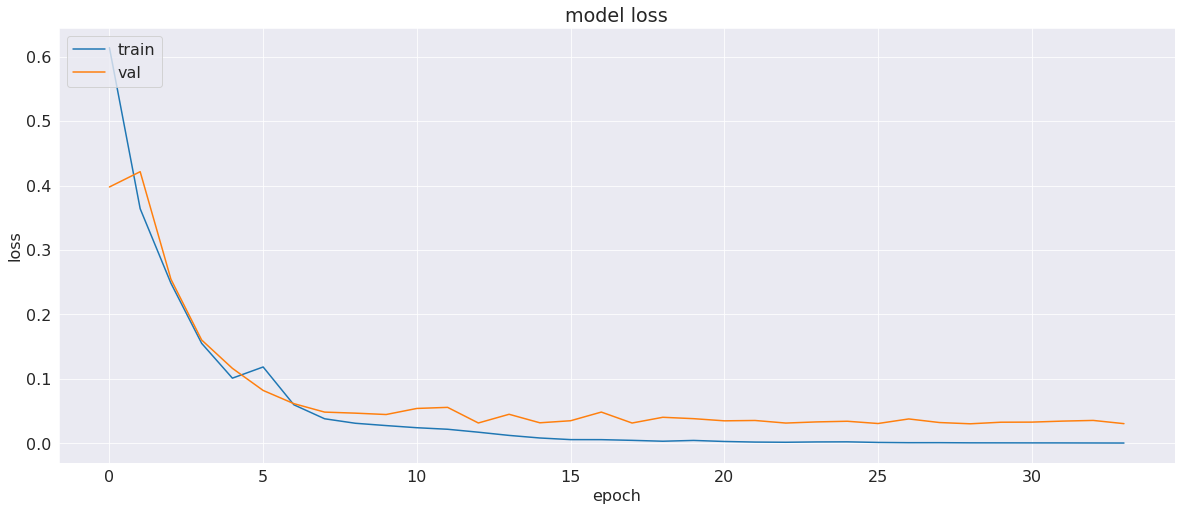

In [29]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

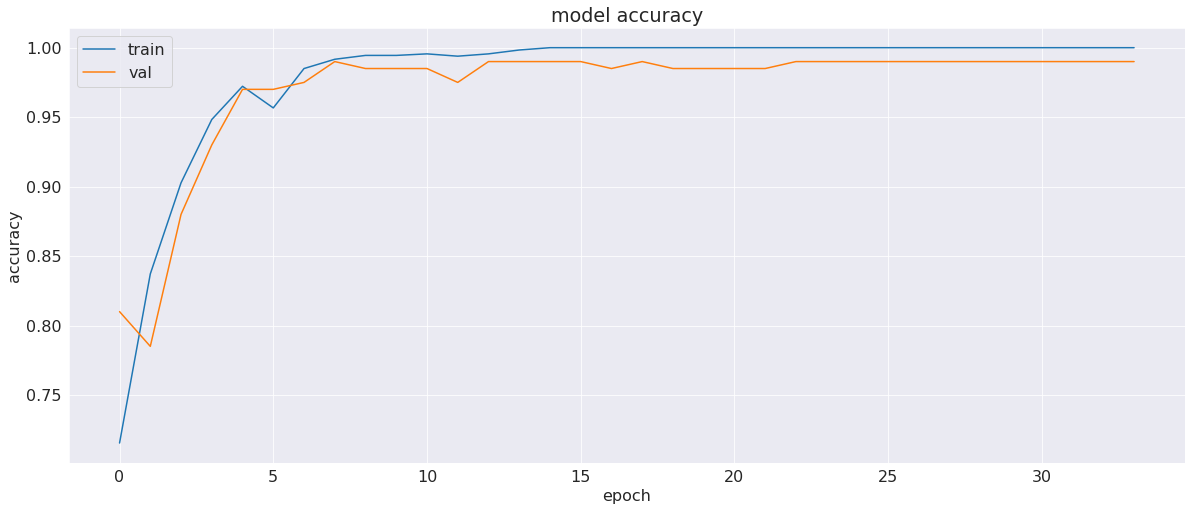

In [50]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
y_pred = model.predict(X_test)

## ROC Curve and AUC Score
- AUC provides an aggregate measure of performance across all possible classification thresholds. The current model is giving us an AUC score of 99%, which means that our model is doing a great job. Since it is extremely close to 1, our model has a very good separability for dysarthric and non dysarthric cases
- The ROC curve is also giving us a good indication that this model will perform well with the threshold of 0.5

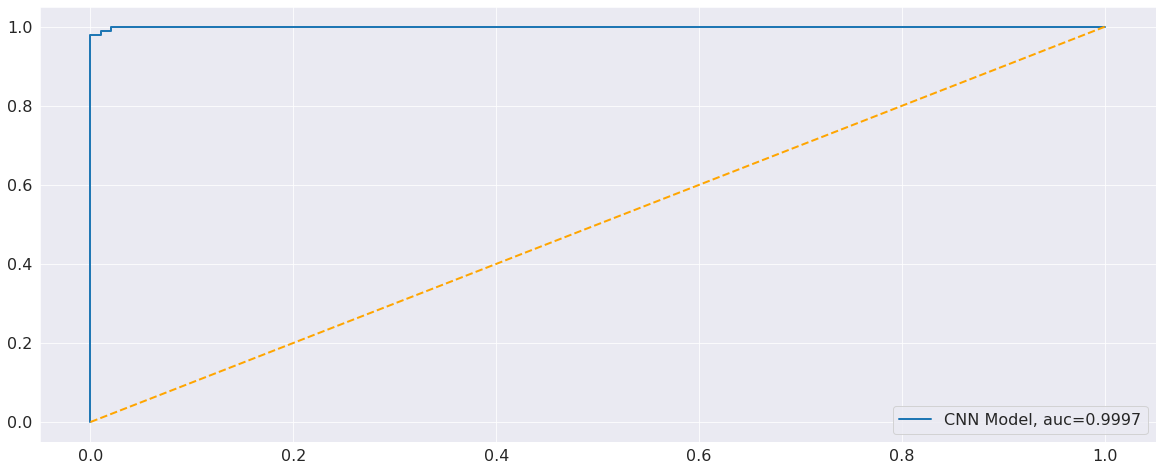

In [46]:
plt.figure(figsize=(20,8))
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="CNN Model, auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [47]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

## Confusion Matrix
- Only 1 misclassification from each class is observed
- Upon running the model several times the performance still remains the same

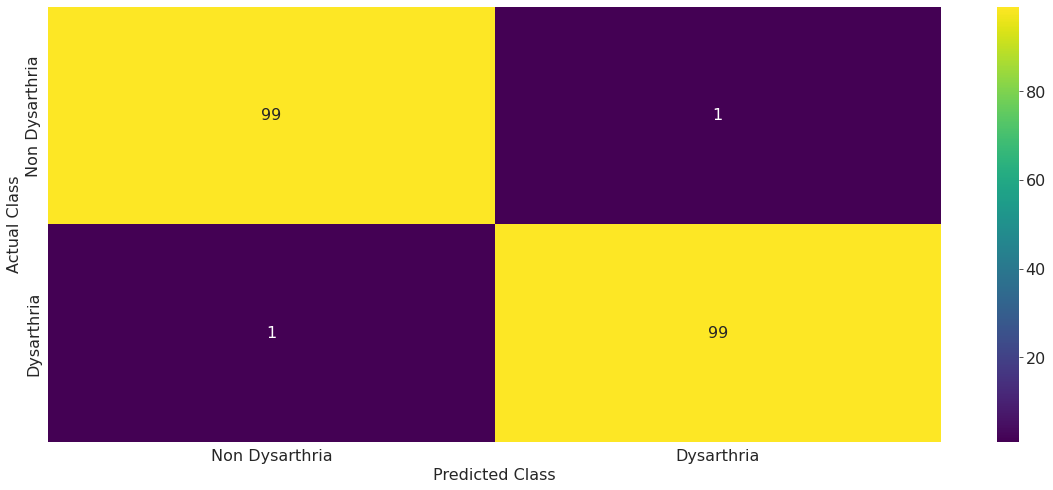

In [48]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

## Classification Report
- Since this is a problem linked to medical domain, it is important that we consider the **Recall** score
- Recall is the measure of what proportion of actual positives were correctly classified, as we do not want to misclassify a dysarthric patient as non dysarthric

<img src='https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png'>

In [49]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       100
         1.0       0.99      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [53]:
print("Recall Score of the Model: ",recall_score(y_test,y_pred))

Recall Score of the Model:  0.99


<div style='font-size: 18px'><strong>Conclusion:</strong> Since the Recall is 99% we can rest assured that our model is doing a good job. An overenthusiastic approach would be to try and make this score 100% to avoid any grave misclassifications<div>